# Conv-6: Weights Distribution Before and After Training

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math, os, time

# from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import AveragePooling2D, Conv2D, MaxPooling2D, ReLU
from tensorflow.keras import models, layers, datasets
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.initializers import RandomNormal

from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.5.0


In [ ]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 2

In [7]:
gpu = tf.config.list_physical_devices('GPU')
if len(gpu) == 0:
    print("There are no available GPUs")
else:
    print(gpu)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
batch_size = 60
num_classes = 10
num_epochs = 100

In [9]:
# Data preprocessing and cleaning:
# input image dimensions
img_rows, img_cols = 32, 32

# Load CIFAR-10 dataset-
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [10]:
if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

print("\n'input_shape' which will be used = {0}\n".format(input_shape))


'input_shape' which will be used = (32, 32, 3)



In [11]:
# Convert datasets to floating point types-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize the training and testing datasets-
X_train /= 255.0
X_test /= 255.0

In [12]:
# convert class vectors/target to binary class matrices or one-hot encoded values-
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [13]:
print("\nDimensions of training and testing sets are:")
print("X_train.shape = {0}, y_train.shape = {1}".format(X_train.shape, y_train.shape))
print("X_test.shape = {0}, y_test.shape = {1}".format(X_test.shape, y_test.shape))


Dimensions of training and testing sets are:
X_train.shape = (50000, 32, 32, 3), y_train.shape = (50000, 10)
X_test.shape = (10000, 32, 32, 3), y_test.shape = (10000, 10)


### Prepare CIFAR10 dataset for GradientTape training:

In [14]:
# Create training and testing datasets-
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [15]:
train_dataset = train_dataset.shuffle(buffer_size = 20000, reshuffle_each_iteration = True).batch(batch_size = batch_size, drop_remainder = False)
test_dataset = test_dataset.batch(batch_size=batch_size, drop_remainder=False)

In [19]:
# Choose an optimizer and loss function for training-
loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0003)

In [20]:
# Select metrics to measure the error & accuracy of model.
# These metrics accumulate the values over epochs and then
# print the overall result-
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'train_accuracy')

test_loss = tf.keras.metrics.Mean(name = 'test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'test_accuracy')

In [21]:
def conv6_cnn():
    """
    Function to define the architecture of a neural network model
    following Conv-6 architecture for CIFAR-10 dataset and using
    provided parameter which are used to prune the model.
    
    Conv-6 architecture-
    64, 64, pool  -- convolutional layers
    128, 128, pool -- convolutional layers
    256, 256, pool -- convolutional layers
    256, 256, 10  -- fully connected layers
    
    Output: Returns designed and compiled neural network model
    """
    
    l = tf.keras.layers
    
    model = Sequential()
    
    model.add(
        Conv2D(
            filters = 64, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotNormal(),
            strides = (1, 1), padding = 'same',
            input_shape=(32, 32, 3)
        )    
    )
        
    model.add(
        Conv2D(
            filters = 64, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotNormal(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(
        MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        )
    )
    
    model.add(
        Conv2D(
            filters = 128, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotNormal(),
            strides = (1, 1), padding = 'same'
        )
    )

    model.add(
        Conv2D(
            filters = 128, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotNormal(),
            strides = (1, 1), padding = 'same'
        )
    )

    model.add(
        MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        )
    )

    model.add(
        Conv2D(
            filters = 256, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotNormal(),
            strides = (1, 1), padding = 'same'
        )
    )

    model.add(
        Conv2D(
            filters = 256, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotNormal(),
            strides = (1, 1), padding = 'same'
        )
    )

    model.add(
        MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        )
    )
    
    model.add(Flatten())
    
    model.add(
        Dense(
            units = 256, activation='relu',
            kernel_initializer = tf.initializers.GlorotNormal()
        )
    )
    
    model.add(
        Dense(
            units = 256, activation='relu',
            kernel_initializer = tf.initializers.GlorotNormal()
        )
    )
    
    model.add(
        Dense(
            units = 10, activation='softmax'
        )
    )
    
    return model
    

In [22]:
# Initialize a CNN model-
model = conv6_cnn()

In [25]:
# Compile defined CNN-
model.compile(
    loss = loss_fn,
    optimizer = optimizer,
    metrics=['accuracy']
    )

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 256)         2

In [27]:
import tensorflow.keras.backend as K


# METHOD-1: This also counts biases
trainable_wts = np.sum([K.count_params(w) for w in model.trainable_weights])
non_trainable_wts = np.sum([K.count_params(w) for w in model.non_trainable_weights])

print("\nNumber of training weights = {0} and non-trainabel weights = {1}\n".format(
    trainable_wts, non_trainable_wts
))
print("Total number of parameters = {0}\n".format(trainable_wts + non_trainable_wts))


Number of training weights = 2262602 and non-trainabel weights = 0.0

Total number of parameters = 2262602.0



In [31]:
conv1 = model.trainable_weights[0].numpy()
conv2 = model.trainable_weights[2].numpy()
conv3 = model.trainable_weights[4].numpy()
conv4 = model.trainable_weights[6].numpy()
conv5 = model.trainable_weights[8].numpy()
conv6 = model.trainable_weights[10].numpy()

In [32]:
dense1 = model.trainable_weights[12].numpy()
dense2 = model.trainable_weights[14].numpy()
op = model.trainable_weights[16].numpy()

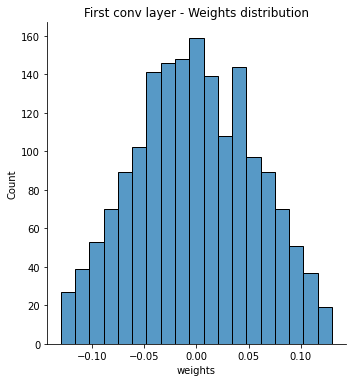

In [33]:
sns.displot(data = conv1.flatten())
plt.title("First conv layer - Weights distribution")
plt.xlabel("weights")
plt.show()

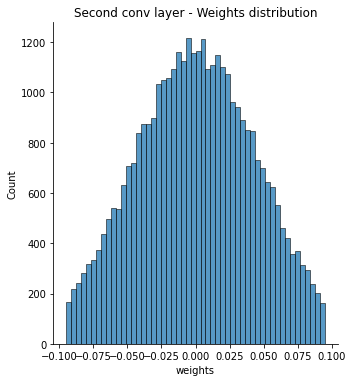

In [34]:
sns.displot(data = conv2.flatten())
plt.title("Second conv layer - Weights distribution")
plt.xlabel("weights")
plt.show()

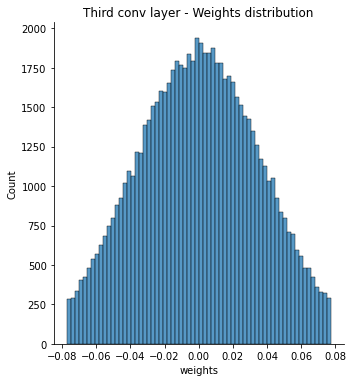

In [35]:
sns.displot(data = conv3.flatten())
plt.title("Third conv layer - Weights distribution")
plt.xlabel("weights")
plt.show()

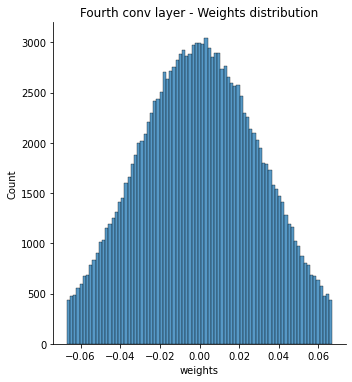

In [36]:
sns.displot(data = conv4.flatten())
plt.title("Fourth conv layer - Weights distribution")
plt.xlabel("weights")
plt.show()

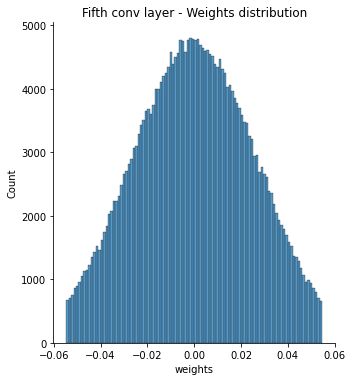

In [37]:
sns.displot(data = conv5.flatten())
plt.title("Fifth conv layer - Weights distribution")
plt.xlabel("weights")
plt.show()

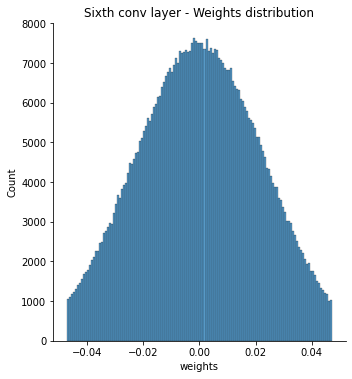

In [38]:
sns.displot(data = conv6.flatten())
plt.title("Sixth conv layer - Weights distribution")
plt.xlabel("weights")
plt.show()

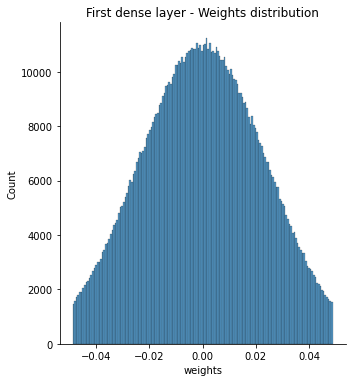

In [39]:
sns.displot(data = dense1.flatten())
plt.title("First dense layer - Weights distribution")
plt.xlabel("weights")
plt.show()

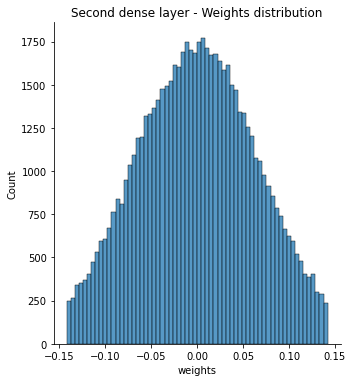

In [40]:
sns.displot(data = dense2.flatten())
plt.title("Second dense layer - Weights distribution")
plt.xlabel("weights")
plt.show()

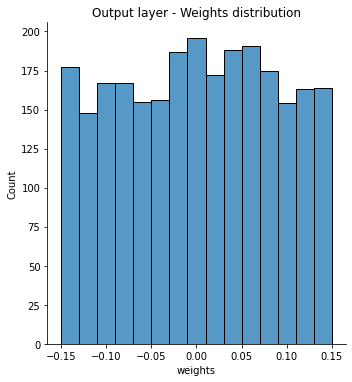

In [41]:
sns.displot(data = op.flatten())
plt.title("Output layer - Weights distribution")
plt.xlabel("weights")
plt.show()

In [42]:
model.save_weights("Conv6_gaussian_random_weights.h5", overwrite = True)

In [53]:
model = conv6_cnn()
model.load_weights("Conv6_gaussian_random_weights.h5")

In [54]:
# Compile pruned CNN-
model.compile(
    loss = loss_fn,
    optimizer = optimizer,
    metrics=['accuracy']
    )

In [55]:
# Define early stopping callback-
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', min_delta = 0.001,
    patience = 3, restore_best_weights = True
)

In [52]:
num_epochs, batch_size

(100, 60)

In [56]:
# Train model-
training_history = model.fit(
    x = X_train, y = y_train,
    epochs = num_epochs, batch_size = batch_size,
    validation_data = (X_test, y_test), shuffle = True,
    callbacks = [early_stopping]
)

Epoch 1/100
834/834 [==============================] - 12s 14ms/step - loss: 1.5592 - accuracy: 0.4188 - val_loss: 1.2058 - val_accuracy: 0.5624
Epoch 2/100
834/834 [==============================] - 11s 14ms/step - loss: 1.0631 - accuracy: 0.6179 - val_loss: 0.9722 - val_accuracy: 0.6565
Epoch 3/100
834/834 [==============================] - 12s 14ms/step - loss: 0.8603 - accuracy: 0.6958 - val_loss: 0.8503 - val_accuracy: 0.6977
Epoch 4/100
834/834 [==============================] - 12s 14ms/step - loss: 0.7298 - accuracy: 0.7437 - val_loss: 0.7420 - val_accuracy: 0.7402
Epoch 5/100
834/834 [==============================] - 12s 15ms/step - loss: 0.6341 - accuracy: 0.7777 - val_loss: 0.7118 - val_accuracy: 0.7528
Epoch 6/100
834/834 [==============================] - 12s 14ms/step - loss: 0.5472 - accuracy: 0.8091 - val_loss: 0.6621 - val_accuracy: 0.7703
Epoch 7/100
834/834 [==============================] - 12s 14ms/step - loss: 0.4705 - accuracy: 0.8353 - val_loss: 0.6647 - val_ac

In [59]:
# Extract weights post training-
conv1 = model.trainable_weights[0].numpy()
conv2 = model.trainable_weights[2].numpy()
conv4 = model.trainable_weights[6].numpy()
conv6 = model.trainable_weights[8].numpy()

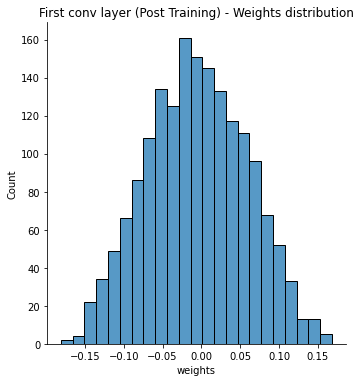

In [60]:
sns.displot(data = conv1.flatten())
plt.title("First conv layer (Post Training) - Weights distribution")
plt.xlabel("weights")
plt.show()

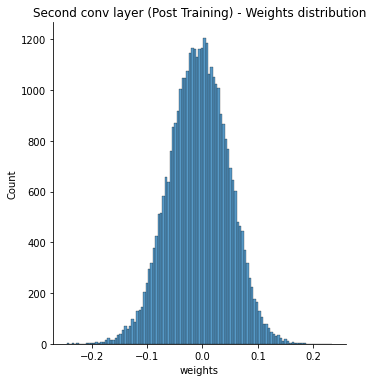

In [61]:
sns.displot(data = conv2.flatten())
plt.title("Second conv layer (Post Training) - Weights distribution")
plt.xlabel("weights")
plt.show()

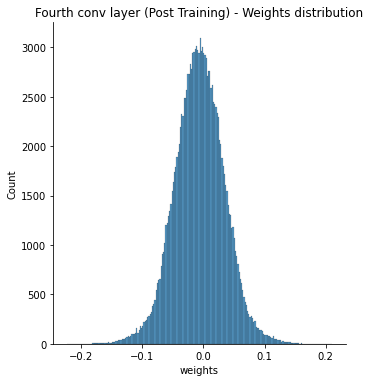

In [62]:
sns.displot(data = conv4.flatten())
plt.title("Fourth conv layer (Post Training) - Weights distribution")
plt.xlabel("weights")
plt.show()

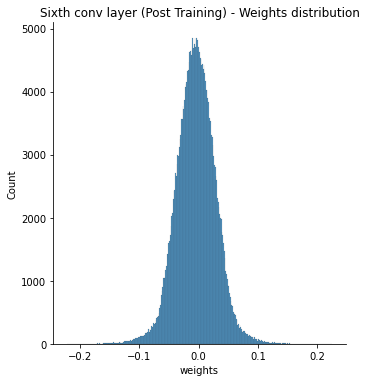

In [63]:
sns.displot(data = conv6.flatten())
plt.title("Sixth conv layer (Post Training) - Weights distribution")
plt.xlabel("weights")
plt.show()

In [64]:
dense1 = model.trainable_weights[12].numpy()
dense2 = model.trainable_weights[14].numpy()
op = model.trainable_weights[16].numpy()

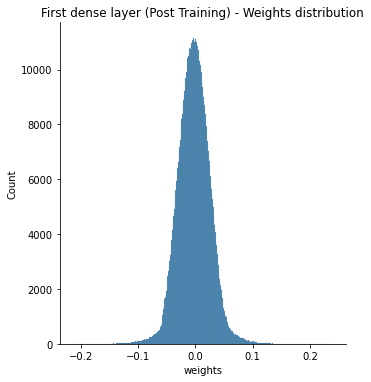

In [65]:
sns.displot(data = dense1.flatten())
plt.title("First dense layer (Post Training) - Weights distribution")
plt.xlabel("weights")
plt.show()

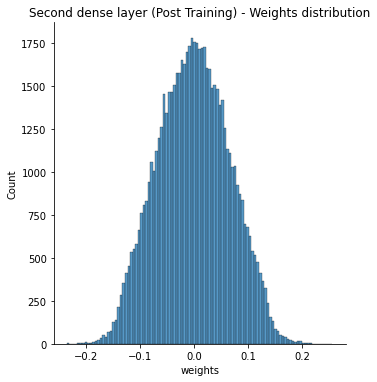

In [66]:
sns.displot(data = dense2.flatten())
plt.title("Second dense layer (Post Training) - Weights distribution")
plt.xlabel("weights")
plt.show()

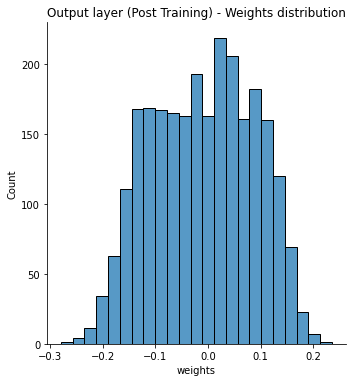

In [67]:
sns.displot(data = op.flatten())
plt.title("Output layer (Post Training) - Weights distribution")
plt.xlabel("weights")
plt.show()

In [68]:
def conv6_cnn_uniform():
    """
    Function to define the architecture of a neural network model
    following Conv-6 architecture for CIFAR-10 dataset and using
    provided parameter which are used to prune the model.
    
    Conv-6 architecture-
    64, 64, pool  -- convolutional layers
    128, 128, pool -- convolutional layers
    256, 256, pool -- convolutional layers
    256, 256, 10  -- fully connected layers
    
    Output: Returns designed and compiled neural network model
    """
    
    l = tf.keras.layers
    
    model = Sequential()
    
    model.add(
        Conv2D(
            filters = 64, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'same',
            input_shape=(32, 32, 3)
        )    
    )
        
    model.add(
        Conv2D(
            filters = 64, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(
        MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        )
    )
    
    model.add(
        Conv2D(
            filters = 128, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'same'
        )
    )

    model.add(
        Conv2D(
            filters = 128, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'same'
        )
    )

    model.add(
        MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        )
    )

    model.add(
        Conv2D(
            filters = 256, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'same'
        )
    )

    model.add(
        Conv2D(
            filters = 256, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'same'
        )
    )

    model.add(
        MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        )
    )
    
    model.add(Flatten())
    
    model.add(
        Dense(
            units = 256, activation='relu',
            kernel_initializer = tf.initializers.GlorotUniform()
        )
    )
    
    model.add(
        Dense(
            units = 256, activation='relu',
            kernel_initializer = tf.initializers.GlorotUniform()
        )
    )
    
    model.add(
        Dense(
            units = 10, activation='softmax'
        )
    )
    
    return model
    

In [69]:
model_uniform = conv6_cnn_uniform()

In [70]:
# Compile defined CNN-
model_uniform.compile(
    loss = loss_fn,
    optimizer = optimizer,
    metrics=['accuracy']
    )


In [71]:
model_uniform.save_weights("Conv6_uniform_random_weights.h5", overwrite = True)

In [72]:
# Extract weights before training-
conv1 = model_uniform.trainable_weights[0].numpy()
conv2 = model_uniform.trainable_weights[2].numpy()
conv3 = model_uniform.trainable_weights[4].numpy()
conv4 = model_uniform.trainable_weights[6].numpy()
conv5 = model_uniform.trainable_weights[8].numpy()
conv6 = model_uniform.trainable_weights[10].numpy()

In [73]:
dense1 = model_uniform.trainable_weights[12].numpy()
dense2 = model_uniform.trainable_weights[14].numpy()
op = model_uniform.trainable_weights[16].numpy()

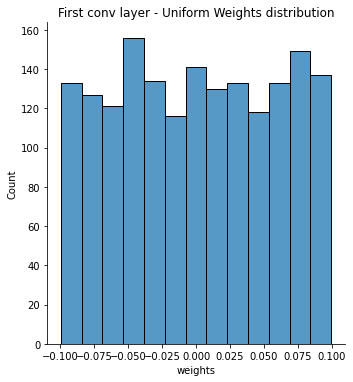

In [74]:
sns.displot(data = conv1.flatten())
plt.title("First conv layer - Uniform Weights distribution")
plt.xlabel("weights")
plt.show()

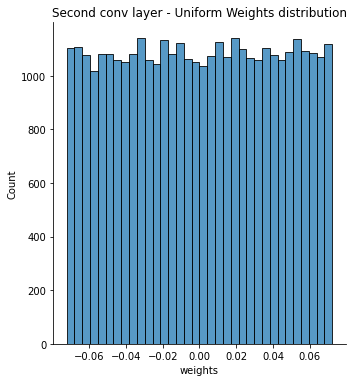

In [75]:
sns.displot(data = conv2.flatten())
plt.title("Second conv layer - Uniform Weights distribution")
plt.xlabel("weights")
plt.show()

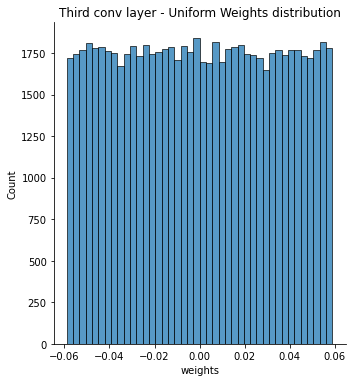

In [76]:
sns.displot(data = conv3.flatten())
plt.title("Third conv layer - Uniform Weights distribution")
plt.xlabel("weights")
plt.show()

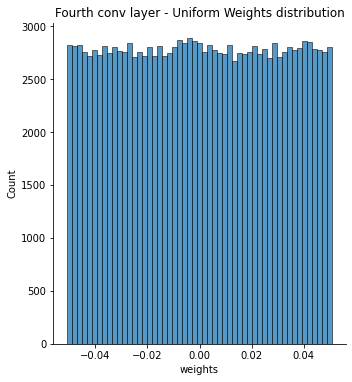

In [77]:
sns.displot(data = conv4.flatten())
plt.title("Fourth conv layer - Uniform Weights distribution")
plt.xlabel("weights")
plt.show()

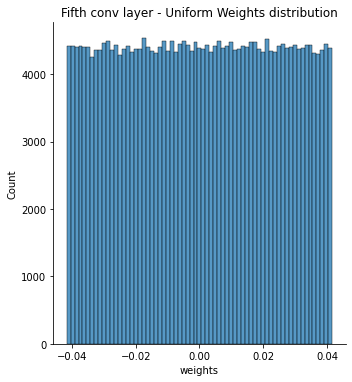

In [78]:
sns.displot(data = conv5.flatten())
plt.title("Fifth conv layer - Uniform Weights distribution")
plt.xlabel("weights")
plt.show()

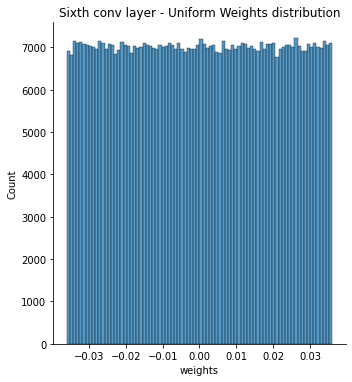

In [79]:
sns.displot(data = conv6.flatten())
plt.title("Sixth conv layer - Uniform Weights distribution")
plt.xlabel("weights")
plt.show()

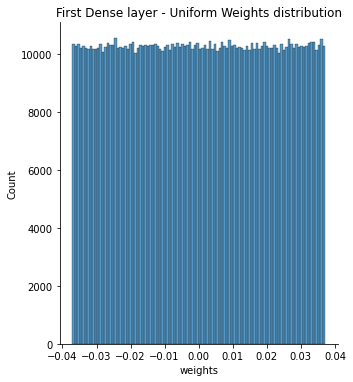

In [80]:
sns.displot(data = dense1.flatten())
plt.title("First Dense layer - Uniform Weights distribution")
plt.xlabel("weights")
plt.show()

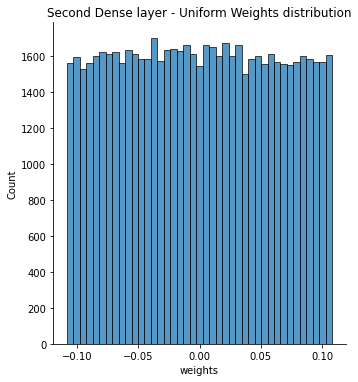

In [81]:
sns.displot(data = dense2.flatten())
plt.title("Second Dense layer - Uniform Weights distribution")
plt.xlabel("weights")
plt.show()

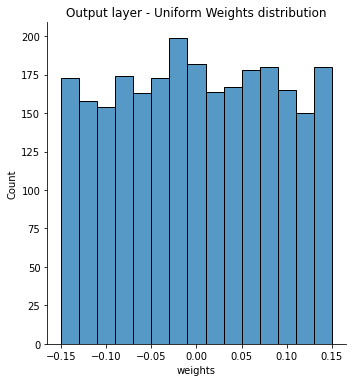

In [82]:
sns.displot(data = op.flatten())
plt.title("Output layer - Uniform Weights distribution")
plt.xlabel("weights")
plt.show()

In [83]:
# Train model-
training_uniform_history = model_uniform.fit(
    x = X_train, y = y_train,
    epochs = num_epochs, batch_size = batch_size,
    validation_data = (X_test, y_test), shuffle = True,
    callbacks = [early_stopping]
)

Epoch 1/100
834/834 [==============================] - 12s 14ms/step - loss: 1.6243 - accuracy: 0.3977 - val_loss: 1.2245 - val_accuracy: 0.5626
Epoch 2/100
834/834 [==============================] - 12s 14ms/step - loss: 1.0453 - accuracy: 0.6266 - val_loss: 0.9504 - val_accuracy: 0.6607
Epoch 3/100
834/834 [==============================] - 12s 14ms/step - loss: 0.8425 - accuracy: 0.7004 - val_loss: 0.8229 - val_accuracy: 0.7124
Epoch 4/100
834/834 [==============================] - 12s 14ms/step - loss: 0.7104 - accuracy: 0.7476 - val_loss: 0.7946 - val_accuracy: 0.7238
Epoch 5/100
834/834 [==============================] - 12s 15ms/step - loss: 0.6156 - accuracy: 0.7834 - val_loss: 0.7526 - val_accuracy: 0.7423
Epoch 6/100
834/834 [==============================] - 12s 14ms/step - loss: 0.5299 - accuracy: 0.8127 - val_loss: 0.7345 - val_accuracy: 0.7556
Epoch 7/100
834/834 [==============================] - 12s 14ms/step - loss: 0.4464 - accuracy: 0.8430 - val_loss: 0.7399 - val_ac

In [84]:
# Extract weights after model has been trained:
# Extract weights before training-
conv1 = model_uniform.trainable_weights[0].numpy()
conv2 = model_uniform.trainable_weights[2].numpy()
conv3 = model_uniform.trainable_weights[4].numpy()
conv4 = model_uniform.trainable_weights[6].numpy()
conv5 = model_uniform.trainable_weights[8].numpy()
conv6 = model_uniform.trainable_weights[10].numpy()

dense1 = model_uniform.trainable_weights[12].numpy()
dense2 = model_uniform.trainable_weights[14].numpy()
op = model_uniform.trainable_weights[16].numpy()

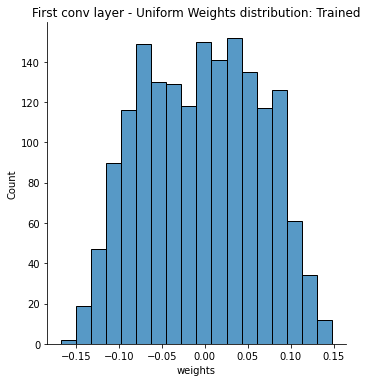

In [85]:
sns.displot(data = conv1.flatten())
plt.title("First conv layer - Uniform Weights distribution: Trained")
plt.xlabel("weights")
plt.show()

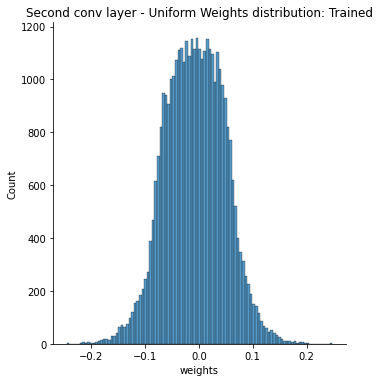

In [86]:
sns.displot(data = conv2.flatten())
plt.title("Second conv layer - Uniform Weights distribution: Trained")
plt.xlabel("weights")
plt.show()

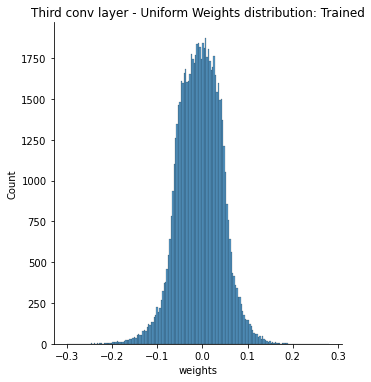

In [87]:
sns.displot(data = conv3.flatten())
plt.title("Third conv layer - Uniform Weights distribution: Trained")
plt.xlabel("weights")
plt.show()

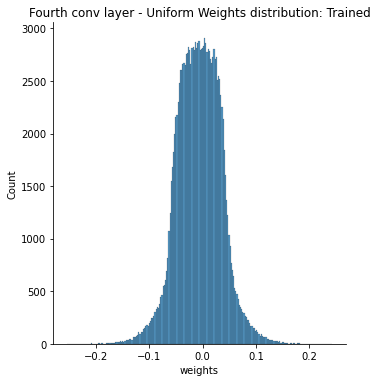

In [88]:
sns.displot(data = conv4.flatten())
plt.title("Fourth conv layer - Uniform Weights distribution: Trained")
plt.xlabel("weights")
plt.show()

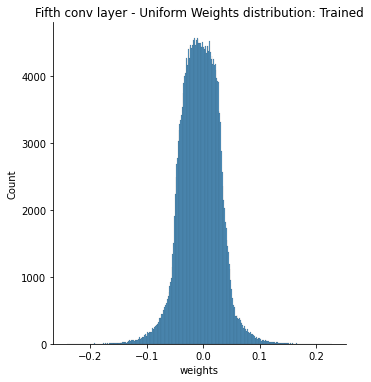

In [89]:
sns.displot(data = conv5.flatten())
plt.title("Fifth conv layer - Uniform Weights distribution: Trained")
plt.xlabel("weights")
plt.show()

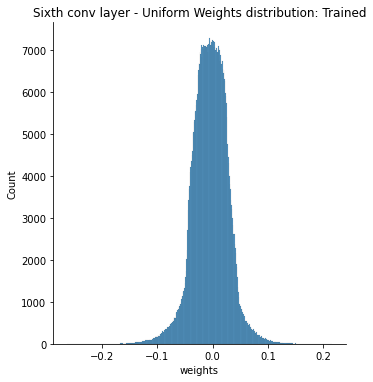

In [90]:
sns.displot(data = conv6.flatten())
plt.title("Sixth conv layer - Uniform Weights distribution: Trained")
plt.xlabel("weights")
plt.show()

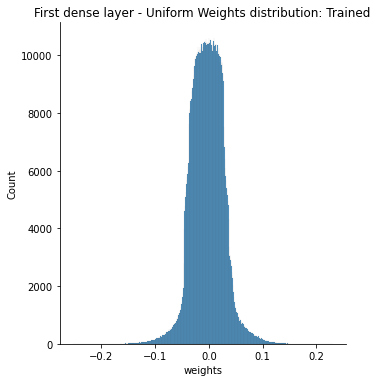

In [91]:
sns.displot(data = dense1.flatten())
plt.title("First dense layer - Uniform Weights distribution: Trained")
plt.xlabel("weights")
plt.show()

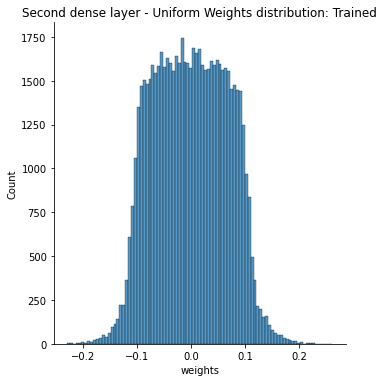

In [92]:
sns.displot(data = dense2.flatten())
plt.title("Second dense layer - Uniform Weights distribution: Trained")
plt.xlabel("weights")
plt.show()

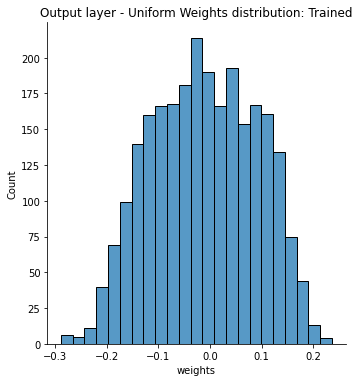

In [93]:
sns.displot(data = op.flatten())
plt.title("Output layer - Uniform Weights distribution: Trained")
plt.xlabel("weights")
plt.show()

In [94]:
# Save trained weights/model-
model.save_weights("Conv6_gaussian_trained_weights.h5", overwrite = True)

In [95]:
model_uniform.save_weights("Conv6_uniform_trained_weights.h5", overwrite = True)